# Project 2 solution: computing area by random sampling

## Problem statement

**Goal:** Sample random number pairs $x \in (-1, 1)$, $y \in (-1, 1)$ with a uniform distribution to compute the area of a circle with radius $r = 1$. Then use the area $A = \pi r^2$ formula to derive $\pi$.

* How does the accuracy depend on number of sampled pairs?
* What about the computation time?

**Stretch goal:** Use the same technique to compute the area of the Mandelbrot set. The Mandelbrot set is the set of complex numbers $c \in \Bbb{C}$ such that the sequence $z_0 = 0$, $z_{n+1} = {z_n}^2 + c$ does not diverge to infinity as $n \to \infty$.

The following CUDA device function identifies whether a point $c = x + y\,i$ ($x \in \Bbb{R}$, $y \in \Bbb{R}$, $i = \sqrt{-1}$) is in the Mandelbrot set, using [Floyd's algorithm](https://en.wikipedia.org/wiki/Cycle_detection#Floyd's_tortoise_and_hare) to detect cycles and convergence to zero.

```python
@nb.cuda.jit(device=True)
def is_in_mandelbrot(x, y):
    c = np.complex64(x) + np.complex64(y)*np.complex64(1j)
    z_hare = z_tortoise = np.complex64(0)
    while True:
        z_hare = z_hare*z_hare + c
        z_hare = z_hare*z_hare + c
        z_tortoise = z_tortoise*z_tortoise + c
        if z_hare == z_tortoise:
            return True      # orbiting or converging to zero
        if z_hare.real**2 + z_hare.imag**2 > 4:
            return False     # diverging to infinity
```

You can assume that the Mandelbrot set is entirely contained within $x \in (-2, 1)$, $y \in (-\frac{3}{2}, \frac{3}{2})$, which has area $9$ (see [[Knill (2023)](https://doi.org/10.48550/arXiv.2305.17848)], section 4.7).

The exact area of the Mandelbrot set is not known, mathematically. There is an expression,

$$\mbox{area of Mandelbrot set} = \pi \left( 1 - \sum_{n=1}^\infty n \, {b_n}^2 \right)$$

in which the terms $b_n$ can be determined recursively, but it converges very slowly: $10^{118}$ terms are needed to get the first 2 digits, and $10^{1181}$ terms are needed to get 3 digits [[Ewing & Schober (1992)](https://doi.org/10.1007/BF01385497)]. The best estimates of the Mandelbrot set's area come from sampling techniques like this one. The most recent publication is [[Bittner, Cheong, Gates, & Nguyen (2012)](https://doi.org/10.2140/involve.2017.10.555)] and the most recent unpublished estimate is [[Förstemann (2017)](https://www.foerstemann.name/labor.html)] using 2× Radeon HD 5970 and a tree-splitting (rather than random) search. The most precise, rigorous bounds to date are

$$1.50640 < \mbox{area of Mandelbrot set} < 1.53121\mbox{.}$$

If you're interested in this sort of thing, Robert Munafo wrote a [rabbit warren of hyperlinked pages](http://www.mrob.com/pub/muency/areaofthemandelbrotset.html) about all of the techniques in 2003, from a [Usenet thread (alt.fractals)](https://ics.uci.edu/~eppstein/junkyard/mand-area.html) that started exactly 5 days after the [first release of Python (alt.sources)](https://www.tuhs.org/Usenet/alt.sources/1991-February/001749.html). Weird, huh?

<br><br><br><br><br>

## Computing π from the area of a circle

### Initial exploration

If we try to jump directly to the solution, the final area estimate, we're likely to make a mistake and get something like zero or an area that does not converge as the number of samples increases. (_I_ am, anyway.) Usually, this is because of mistakes like cutting off the region of interest, getting $x$ and $y$ as the same value, or failing to fill the output buffer.

Most of these types of mistakes can be caught by looking at the random samples before attempting to compute an area, so let's start with that.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cupy as cp
import numba.cuda
import numba as nb

As described in the lecture, we need to be careful about propagating random seeds. The [`xoroshiro128p` functions](https://numba.readthedocs.io/en/stable/cuda/random.html) in Numba (and [`curand*` functions](https://docs.nvidia.com/cuda/curand/device-api-overview.html#pseudorandom-sequences) in C++ CUDA) do that.

We will want to generate _uniform_ distributions, and we can use 32-bit floats. Also as discussed in the lecture, we can use Python's [`os.urandom` function](https://docs.python.org/3/library/os.html#os.urandom) to set a starting seed.

In [2]:
import os
from numba.cuda.random import create_xoroshiro128p_states, xoroshiro128p_uniform_float32

def starting_seed():
    return np.array(os.urandom(8)).view(np.uint64)

The first attempt should only fill an output array with $x$, $y$ pairs so that we can look at them and confirm that they look uniform on the range we expect.

In [3]:
@nb.cuda.jit
def fill_dots(rng_states, outx, outy):
    thread_idx = nb.cuda.grid(1)
    x = xoroshiro128p_uniform_float32(rng_states, thread_idx)
    y = xoroshiro128p_uniform_float32(rng_states, thread_idx)
    outx[thread_idx] = x
    outy[thread_idx] = y

Since this is exploratory, use a very small number of points.

Run this a few times to see the random numbers change.

/root/miniforge3/envs/2023-11-02-atlas-gpu-python-tutorial/lib/python3.10/site-packages/numba/cuda/dispatcher.py:538: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


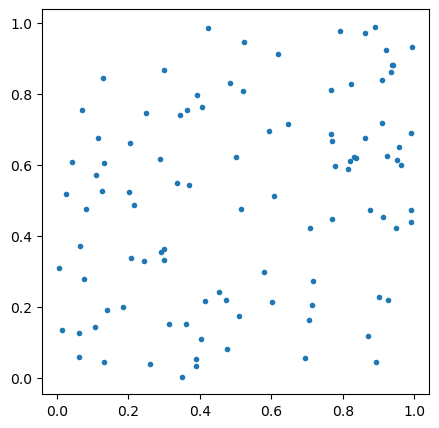

In [4]:
num_threads = 100
num_blocks = 1

rng_states = create_xoroshiro128p_states(num_threads * num_blocks, seed=starting_seed())

outx = cp.zeros(num_threads * num_blocks, dtype=np.float32)
outy = cp.zeros(num_threads * num_blocks, dtype=np.float32)

fill_dots[num_blocks, num_threads](rng_states, outx, outy)

fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(outx.get(), outy.get(), marker=".");

Now let's introduce the circle constraint.

In [5]:
@nb.cuda.jit
def fill_dots_circle(rng_states, outx, outy):
    thread_idx = nb.cuda.grid(1)
    x = xoroshiro128p_uniform_float32(rng_states, thread_idx)
    y = xoroshiro128p_uniform_float32(rng_states, thread_idx)
    if x**2 + y**2 < 1:
        outx[thread_idx] = x
        outy[thread_idx] = y

With enough points, the cookie-cutter should carve out an obvious line.

/root/miniforge3/envs/2023-11-02-atlas-gpu-python-tutorial/lib/python3.10/site-packages/numba/cuda/dispatcher.py:538: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


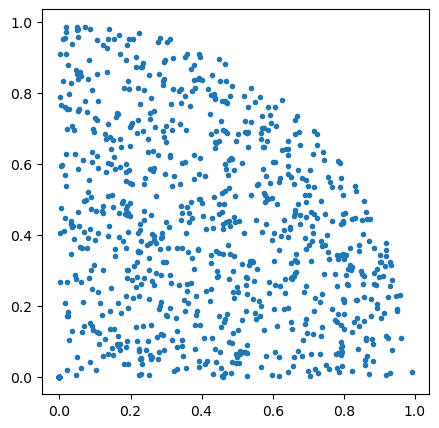

In [6]:
num_threads = 1024
num_blocks = 1

rng_states = create_xoroshiro128p_states(num_threads * num_blocks, seed=starting_seed())

outx = cp.zeros(num_threads * num_blocks, dtype=np.float32)
outy = cp.zeros(num_threads * num_blocks, dtype=np.float32)

fill_dots_circle[num_blocks, num_threads](rng_states, outx, outy)

fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(outx.get(), outy.get(), marker=".");

The problem now is that we're only looking at a quarter of the circle. The `xoroshiro128p_uniform_float32` function generates numbers from $0$ to $1$, but a circle of radius $1$ centered on the origin covers an area that goes from $-1$ to $1$.

We could just use this, calculate $\frac{\pi}{4}$ and then multiply by $4$, but if we use it without recognizing that the area is different, we would get the wrong answer by a factor of $4$.

(This, by the way, is why we start with a problem whose answer we know. Even if our only goal is to compute the area of the Mandelbroit set, we should start with a circle to be sure we're oriented correctly.)

In [7]:
@nb.cuda.jit
def fill_dots_circle_whole_area(rng_states, outx, outy):
    thread_idx = nb.cuda.grid(1)
    x = xoroshiro128p_uniform_float32(rng_states, thread_idx)*2 - 1
    y = xoroshiro128p_uniform_float32(rng_states, thread_idx)*2 - 1
    if x**2 + y**2 < 1:
        outx[thread_idx] = x
        outy[thread_idx] = y

Here comes the sun!

/root/miniforge3/envs/2023-11-02-atlas-gpu-python-tutorial/lib/python3.10/site-packages/numba/cuda/dispatcher.py:538: NumbaPerformanceWarning: Grid size 5 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


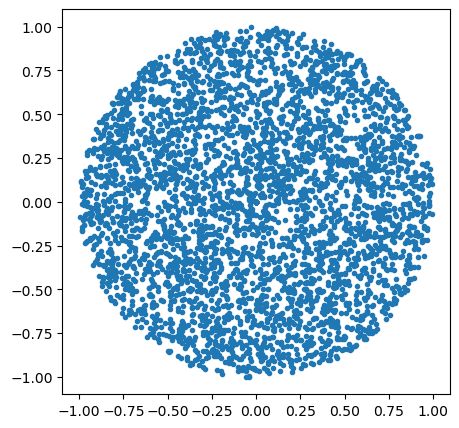

In [8]:
num_threads = 1024
num_blocks = 5

rng_states = create_xoroshiro128p_states(num_threads * num_blocks, seed=starting_seed())

outx = cp.zeros(num_threads * num_blocks, dtype=np.float32)
outy = cp.zeros(num_threads * num_blocks, dtype=np.float32)

fill_dots_circle_whole_area[num_blocks, num_threads](rng_states, outx, outy)

fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(outx.get(), outy.get(), marker=".");

<br><br><br><br><br>

### Strategy for solving the problem

Now we just have to count how many points fall within the circle.

We could use the tree-reduction technique from the previous exercise, but that's built into `cp.sum`.

In [9]:
num_selected = cp.sum(outx != 0)
assert num_selected == cp.sum(outy != 0)
num_selected

../../thread/thread_load.cuh(36): warning: cuda.h: [jitify] File not found
../../thread/thread_store.cuh(36): warning: cuda.h: [jitify] File not found


array(3966)

The number of points that were generated is

In [10]:
num_total = num_threads * num_blocks
num_total

5120

So this is the fraction that passed the selection (must be between 0 and 1):

In [11]:
num_selected / num_total

array(0.77460938)

That's also the fraction of area the circle covers, out of the area that was generated.

The area that was generated was $(1 - -1)^2 = 4$ because we stretched both the generated $x$ to $(-1, 1)$ and the generated $y$ to $(-1, 1)$.

So the area that the circle covers is

In [12]:
4 * num_selected / num_total

array(3.0984375)

It's already looking like π. The area of a circle is $A = \pi r^2$ and this radius $r = 1$, so this value _should_ be π.

Now we just want to scale it up and get more precision.

<br><br><br><br><br>

### Choosing the grid size

Since this problem does not have input data, our only constraints on the number of blocks and threads per block are

* we want to fill all of the available processors (more is better),
* each thread must get a distinct random number seed and must have a distinct output to avoid using atomics (fewer is better).

The number of threads per block should saturate each block.

In [13]:
num_threads = cp.cuda.Device(0).attributes["MaxThreadsPerBlock"]
num_threads

1024

The number of blocks should at least exceed the number of multiprocessors, while being small enough to not waste time generating seeds.

In [14]:
cp.cuda.Device(0).attributes["MultiProcessorCount"]

40

How about

In [15]:
num_blocks = 1024

<br><br><br><br><br>

### Writing a kernel that counts

The previous kernels were intended to display the randomly generated points, so we had each kernel output those values. Our intention now is just to count how many pass the selection, so we can output an integer instead.

We're only interested in the total number, so we might be tempted to make a length-1 array and have each thread increment it. But as we learned earlier in this course, threads updating the same value in parallel can garble it, so it would at least need to be an atomic integer to be valid. Even then, an atomic output would be very slow because every thread would want to increment it at the same time.

Instead, we'll make a `num_in_set` array of integers, with one index position for each thread. We'll add them up later.

In [16]:
@nb.cuda.jit
def count_circle(rng_states, num_in_set):
    thread_idx = nb.cuda.grid(1)
    x = xoroshiro128p_uniform_float32(rng_states, thread_idx)*2 - 1
    y = xoroshiro128p_uniform_float32(rng_states, thread_idx)*2 - 1
    if x**2 + y**2 < 1:
        num_in_set[thread_idx] += 1

rng_states = create_xoroshiro128p_states(num_threads * num_blocks, seed=starting_seed())

num_in_set = cp.zeros(num_threads * num_blocks, dtype=np.int32)

count_circle[num_blocks, num_threads](rng_states, num_in_set)

If an $x$, $y$ pair was within the circle, its `num_in_set[thread_idx]` was incremented to 1; otherwise, it was left at its initial value of 0.

Verify that those are the only values in this array (to catch mistakes due to not initializing).

In [17]:
num_in_set.min(), num_in_set.max()

(array(0, dtype=int32), array(1, dtype=int32))

Now apply the same strategy as in the previous section.

In [18]:
num_selected = num_in_set.sum()
num_total = num_threads * num_blocks

4 * num_selected / num_total

array(3.14237595)

It's π!

<br><br><br><br><br>

### Scaling up

To run this algorithm on more trials, we _could_ increase the number of blocks.

However, more independent threads would require more random seeds, and it's a waste of resources for each random seed to only be used once. (All of the time would go into generating seeds—just setting up—and not running the algorithm at scale.)

So if we want `num_total_trials > num_threads * num_blocks`, how about a `for` loop inside the kernel?

The following solution only works if `num_total_trials` is an integer multiple of `num_threads * num_blocks`, but we can accept that in our scale-up plot, rather than make the kernel more complicated.

In [19]:
@nb.cuda.jit
def count_circle_many_times(rng_states, num_trials, num_in_set):
    thread_idx = nb.cuda.grid(1)
    for _ in range(num_trials):
        x = xoroshiro128p_uniform_float32(rng_states, thread_idx)*2 - 1
        y = xoroshiro128p_uniform_float32(rng_states, thread_idx)*2 - 1
        if x**2 + y**2 < 1:
            num_in_set[thread_idx] += 1

def compute_π(num_total_trials, seed):
    num_threads = 1024
    num_blocks = 1024
    num_trials = num_total_trials // (num_threads * num_blocks)
    assert num_trials > 0
    assert num_trials * num_threads * num_blocks == num_total_trials

    rng_states = create_xoroshiro128p_states(num_threads * num_blocks, seed=seed)
    num_in_set = cp.zeros(num_threads * num_blocks, dtype=np.int32)

    count_circle_many_times[num_blocks, num_threads](rng_states, num_trials, num_in_set)

    return float(4 * num_in_set.sum() / num_total_trials)

In [20]:
compute_π(10 * 1024**2, starting_seed())

3.141720199584961

Now let's see how it approaches π as `num_total_trials` increases.

(If $1024^2$ bytes is called a "mebibyte," then I can call the number $1024^2$ a "mebiyon.")

In [21]:
n_mebiyon = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000]
results = []
for n in n_mebiyon:
    print(f"{n} mebiyon trials")
    results.append(compute_π(n * 1024**2, starting_seed()))

1 mebiyon trials
2 mebiyon trials
5 mebiyon trials
10 mebiyon trials
20 mebiyon trials
50 mebiyon trials
100 mebiyon trials
200 mebiyon trials
500 mebiyon trials
1000 mebiyon trials
2000 mebiyon trials
5000 mebiyon trials
10000 mebiyon trials


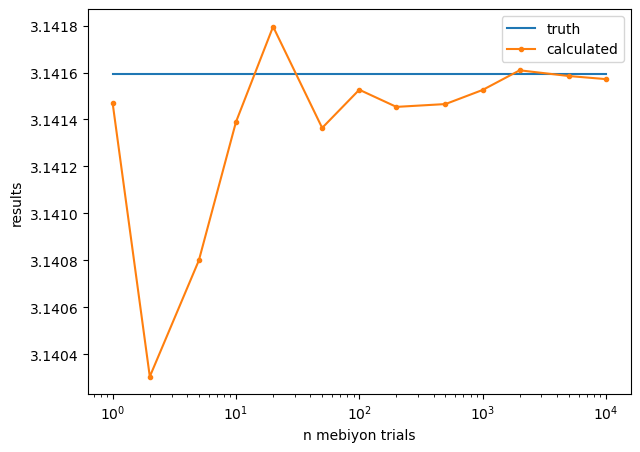

In [22]:
fig, ax = plt.subplots(figsize=(7, 5))

ax.plot([n_mebiyon[0], n_mebiyon[-1]], [np.pi, np.pi], label="truth")
ax.plot(n_mebiyon, results, marker=".", label="calculated")

ax.set_xlabel("n mebiyon trials")
ax.set_ylabel("results")
ax.set_xscale("log")
ax.legend();

Play around with that. How does the computation time scale? Is there anything you can do to reduce it? (Computationally in the problem space or technically in the hardware?)

<br><br><br><br><br>

## Computing the area of the Mandelbrot set

As described in the problem statement, we can determine if a pair of real values $x$, $y$ are in the Mandelbrot set or not by calling this function.

In [23]:
@nb.cuda.jit(device=True)
def is_in_mandelbrot(x, y):
    c = np.complex64(x) + np.complex64(y)*np.complex64(1j)
    z_hare = z_tortoise = np.complex64(0)
    while True:
        z_hare = z_hare*z_hare + c
        z_hare = z_hare*z_hare + c
        z_tortoise = z_tortoise*z_tortoise + c
        if z_hare == z_tortoise:
            return True      # orbiting or converging to zero
        if z_hare.real**2 + z_hare.imag**2 > 4:
            return False     # diverging to infinity

This is a more interesting version of the area-of-a-circle problem because there _isn't_ a better-known way to determine the area of the Mandelbrot set. Unlike a circle, the edge of this set is very complicated. At least we can tell whether a given point is in it or not.

The above algorithm can _potentially_ iterate forever, and if one thread of a warp (group of 32 adjacent threads in CUDA) stalls, all 32 stall. Floyd's "tortoise and hare" algorithm identifies when the iterated system "orbits" ($z_b = z_a$ for some $b > a$) by iterating two copies of $z_n$, one running twice as fast as the other. With 64-bit precision, this takes much longer because the two values must match exactly. If we simply wanted to _draw_ the Mandelbrot set, we could just cut off the number of iterations at, say, 20, but that cut-off has a measurable effect on the area calculation (much more so than 32-bit versus 64-bit). Using a cut-off would be a more GPU-friendly algorithm, but this one is necessary.

<br><br><br><br><br>

### Initial exploration

As with the circle, we should start by visualizing the set to make sure we're correctly generating it and not cutting it off.

The test below doesn't use any random number generation; it scans in a grid and puts the output of `is_in_mandelbrot(x, y)` (either 0 or 1) into a 2-dimensional array that we can view as an image.

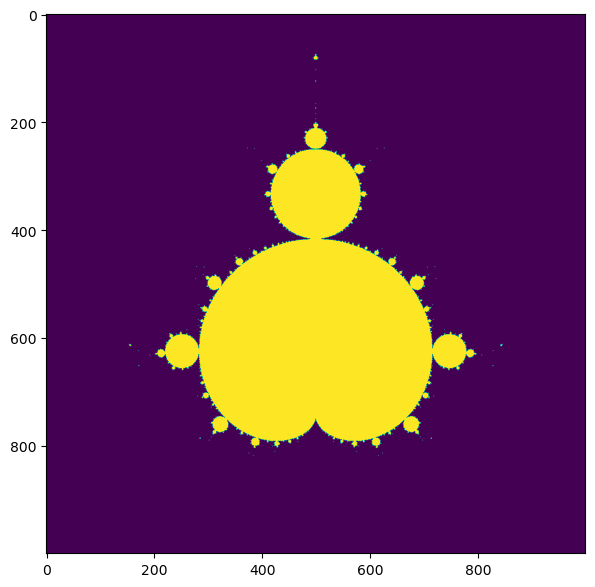

In [24]:
@nb.cuda.jit
def fill_pixel(pixels, xmin, dx, ymin, dy):
    i, j = nb.cuda.grid(2)
    if i < pixels.shape[0] and j < pixels.shape[1]:
        x = xmin + i*dx
        y = ymin + j*dy
        pixels[i, j] = is_in_mandelbrot(x, y)

xmin, xmax = -2, 1
ymin, ymax = -3/2, 3/2

pixels = cp.empty((1000, 1000), np.int32)
dx = (xmax - xmin) / pixels.shape[0]
dy = (ymax - ymin) / pixels.shape[1]

num_threads = (32, 32)
num_blocks = (int(np.ceil(pixels.shape[0] / 32)), int(np.ceil(pixels.shape[1] / 32)))

fill_pixel[num_blocks, num_threads](pixels, xmin, dx, ymin, dy)

fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(pixels.get());

<br><br><br><br><br>

### Writing the kernel and the kernel-runner

Most of the same issues—aligning the figure in the box, random number generation, optimization of CUDA grid—are the same as they were for the circle, so let's jump to the solution.

In [25]:
@nb.cuda.jit
def count_mandelbrot_many_times(rng_states, num_trials, num_in_set):
    thread_idx = nb.cuda.grid(1)
    for _ in range(num_trials):
        x = xoroshiro128p_uniform_float32(rng_states, thread_idx)*3 - 2
        y = xoroshiro128p_uniform_float32(rng_states, thread_idx)*3 - 3/2
        if is_in_mandelbrot(x, y):
            num_in_set[thread_idx] += 1

def compute_mandelbrot_area(num_total_trials, seed):
    num_threads = 1024
    num_blocks = 1024
    num_trials = num_total_trials // (num_threads * num_blocks)
    assert num_trials > 0
    assert num_trials * num_threads * num_blocks == num_total_trials

    rng_states = create_xoroshiro128p_states(num_threads * num_blocks, seed=seed)
    num_in_set = cp.zeros(num_threads * num_blocks, dtype=np.int32)

    count_mandelbrot_many_times[num_blocks, num_threads](rng_states, num_trials, num_in_set)

    return float(9 * num_in_set.sum() / num_total_trials)

In [31]:
compute_mandelbrot_area(10 * 1024**2, starting_seed())

1.50743408203125

The most precise, rigorous bounds for the area of the Mandelbrot set are

$$1.50640 < \mbox{area of Mandelbrot set} < 1.53121\mbox{,}$$

but random sampling yields values that are close to the low bound in most of the references. If you got a value close to 1.506, great! If not, run it again—you might be seeing a fluctuation.

<br><br><br><br><br>

### Scaling up

We're also ready to make the scale-up plot.

In [27]:
n_mebiyon = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]
results = []
for n in n_mebiyon:
    print(f"{n} mebiyon trials")
    results.append(compute_mandelbrot_area(n * 1024**2, starting_seed()))

1 mebiyon trials
2 mebiyon trials
5 mebiyon trials
10 mebiyon trials
20 mebiyon trials
50 mebiyon trials
100 mebiyon trials
200 mebiyon trials
500 mebiyon trials
1000 mebiyon trials


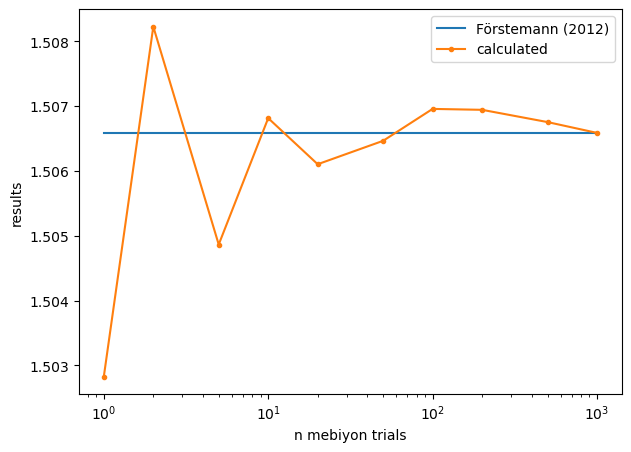

In [28]:
fig, ax = plt.subplots(figsize=(7, 5))

ax.plot([n_mebiyon[0], n_mebiyon[-1]], [1.50659] * 2, label="Förstemann (2012)")
ax.plot(n_mebiyon[:len(results)], results, marker=".", label="calculated")

ax.set_xlabel("n mebiyon trials")
ax.set_ylabel("results")
ax.set_xscale("log")
ax.legend();

A lot more care would be needed to turn this into a paper, but it's interesting to note that it wouldn't take much more computational power to narrow the limits on a fundamental quantity in mathematics.